In [53]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

vocabulary_size = 500
global_truncate = True

#Create a SparkSession
spark = SparkSession.builder \
    .appName('app_name') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','16g') \
    .config("spark.executor.memory", "16g") \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [54]:
from pyspark.sql import functions as func
from pyspark.sql.functions import length

data = spark.read.csv(
    'train.csv', 
    header=True,
    inferSchema=True,
    escape='"'
)


In [62]:
# Clean Text
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re

# # Define a UDF (User-Defined Function) to remove symbols and convert to lowercase
# def remove_symbols(text):
#     cleaned_text = re.sub(r"[^\w\s]", "", text)
#     lowercase_text = cleaned_text.lower()
#     return lowercase_text

# # Register the UDF
# udf_remove_symbols = udf(remove_symbols, StringType())
# spark.udf.register("remove_symbols", udf_remove_symbols)

# # Define the SQLTransformer stage to apply the UDF
# sql_transformer = SQLTransformer(
#     statement="SELECT *, remove_symbols(text) AS cleaned_text FROM __THIS__"
# )

# data = sql_transformer.transform(data)

# Lemmatization of words in text
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StringType
from nltk.stem import WordNetLemmatizer
import nltk


# using wordnet to lemmatize text
# download wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

# custom function to lemmatize text.  
# text is in a series so must adjust function to accept series
# cannot just pass text assuming it is a string
def lemmatize(text_series):
    lemm = WordNetLemmatizer()
    return text_series.apply(lambda text: ' '.join([lemm.lemmatize(x) for x in text.split()]))


# custom pandas function to apply to pyspark df
lemm_udf = pandas_udf(lemmatize, returnType=StringType())

# add column with lemmatize data
data = data.withColumn('lemmatized_txt', lemm_udf('text'))

data.show()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/christian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/christian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


+------+-------+--------------------+--------------------+-----------+---------------+--------------------+---------+--------------------+--------------------+--------------------+
|author|     id|                text|        cleaned_text|text_length|author_category|     lexical_density|num_words|        cleaned_text|      lemmatized_txt|        cleaned_text|
+------+-------+--------------------+--------------------+-----------+---------------+--------------------+---------+--------------------+--------------------+--------------------+
|   EAP|id26305|This process, how...|this process howe...|        231|          wordy|0.003099124122294439|       41|this process howe...|This process, how...|this process howe...|
|   HPL|id17569|It never once occ...|it never once occ...|         71|          wordy|0.003865561403524783|       14|it never once occ...|It never once occ...|it never once occ...|
|   EAP|id11008|In his left hand ...|in his left hand ...|        200|          wordy|0.0030991

In [56]:
# data = data.withColumn("text", func.regexp_replace("text", '"', ''))
# data = data.withColumn('text_length', length(data['text']))

# data.createOrReplaceTempView("spooky_sentences")

# result_df = spark.sql(
#     '''
#     SELECT 
#         text AS sentence,
#         text_length,
#         author,
#         size(split(text, ' ')) AS word_count
#     FROM
#         spooky_sentences
#     ORDER BY 
#         word_count DESC
    
#     '''
# )

# print(data.show())


+-------+--------------------+------+--------------------+-----------+
|     id|                text|author|        cleaned_text|text_length|
+-------+--------------------+------+--------------------+-----------+
|id26305|This process, how...|   EAP|this process howe...|        231|
|id17569|It never once occ...|   HPL|it never once occ...|         71|
|id11008|In his left hand ...|   EAP|in his left hand ...|        200|
|id27763|How lovely is spr...|   MWS|how lovely is spr...|        206|
|id12958|Finding nothing e...|   HPL|finding nothing e...|        174|
|id22965|A youth passed in...|   MWS|a youth passed in...|        468|
|id09674|The astronomer, p...|   EAP|the astronomer pe...|        128|
|id13515|The surcingle hun...|   EAP|the surcingle hun...|         43|
|id19322|I knew that you c...|   EAP|i knew that you c...|        488|
|id00912|I confess that ne...|   MWS|i confess that ne...|        144|
|id16737|He shall find tha...|   MWS|he shall find tha...|        106|
|id166

In [63]:
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StringType

# custom function to categorize authors according to text.  
# text is in a series so must adjust function to accept series
# cannot just pass text assuming it is a string
def author_category(wrd_cnt):
    
    return wrd_cnt.apply(
        lambda x: "wordy" if x > 30 else (
            "pity" if x < 7 else "not wordy"
        )
    )

# custom pandas function to apply to pyspark df
auth_cat_udf = pandas_udf(author_category, returnType=StringType())

# add column with author_category data
data = data.withColumn('author_category', auth_cat_udf('text_length'))

print(data)

word_count=data.groupBy('author_category').count().orderBy('count',ascending=False)
word_count.show()

+------+-------+--------------------+--------------------+-----------+---------------+--------------------+---------+--------------------+--------------------+--------------------+
|author|     id|                text|        cleaned_text|text_length|author_category|     lexical_density|num_words|        cleaned_text|      lemmatized_txt|        cleaned_text|
+------+-------+--------------------+--------------------+-----------+---------------+--------------------+---------+--------------------+--------------------+--------------------+
|   EAP|id26305|This process, how...|this process howe...|        231|          wordy|0.003099124122294439|       41|this process howe...|This process, how...|this process howe...|
|   HPL|id17569|It never once occ...|it never once occ...|         71|          wordy|0.003865561403524783|       14|it never once occ...|It never once occ...|it never once occ...|
|   EAP|id11008|In his left hand ...|in his left hand ...|        200|          wordy|0.0030991

+---------------+-----+
|author_category|count|
+---------------+-----+
|          wordy|19031|
|      not wordy|  548|
+---------------+-----+



In [68]:
from pyspark.sql.functions import size, split

data.createOrReplaceTempView("dataset_table")

#Perform SQL query to compare lexical density across authors
query4 = """
SELECT author, COUNT(DISTINCT word) / CAST(SUM(size(split(text, ' '))) AS FLOAT) AS lexical_density
FROM (
    SELECT author, explode(split(lower(text), ' ')) AS word, text
    FROM dataset_table
) subquery
GROUP BY author
ORDER BY lexical_density DESC
"""
lexical_density_comparison = spark.sql(query4)
# lexical_density_comparison.show()
data.drop('lexical_density')
data = data.join(lexical_density_comparison, on='author', how='inner')
# number of words in text
data = data.withColumn('num_words', size(split(data['text'], ' ')))
# lexical density times the number of words in the text

# @todo fix lexical density
print(data.select('author', 'text_length', 'author_category', 'num_words', 'lemmatized_txt'))
# data = data.withColumn('density_x_words', data['lexical_density']*data['num_words'])

# lex_dens = data.groupBy('author').agg({'lexical_density':'average'}).orderBy('avg(lexical_density)',ascending=False)
# lex_dens.show(truncate=True)

+------+-------+--------------------+--------------------+-----------+---------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|author|     id|                text|        cleaned_text|text_length|author_category|     lexical_density|num_words|        cleaned_text|      lemmatized_txt|        cleaned_text|     lexical_density|
+------+-------+--------------------+--------------------+-----------+---------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|   EAP|id26305|This process, how...|this process howe...|        231|          wordy|0.003099124122294439|       41|this process howe...|This process, how...|this process howe...|0.003099124122294439|
|   HPL|id17569|It never once occ...|it never once occ...|         71|          wordy|0.003865561403524783|       14|it never once occ...|It never once occ...|it never once occ...|0.0038655614

+------+-------+--------------------+--------------------+-----------+---------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|author|     id|                text|        cleaned_text|text_length|author_category|     lexical_density|num_words|        cleaned_text|      lemmatized_txt|        cleaned_text|     lexical_density|
+------+-------+--------------------+--------------------+-----------+---------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|   EAP|id26305|This process, how...|this process howe...|        231|          wordy|0.003099124122294439|       41|this process howe...|This process, how...|this process howe...|0.003099124122294439|
|   HPL|id17569|It never once occ...|it never once occ...|         71|          wordy|0.003865561403524783|       14|it never once occ...|It never once occ...|it never once occ...|0.0038655614

+------+-----------+---------------+---------+--------------------+
|author|text_length|author_category|num_words|      lemmatized_txt|
+------+-----------+---------------+---------+--------------------+
|   EAP|        231|          wordy|       41|This process, how...|
|   HPL|         71|          wordy|       14|It never once occ...|
|   EAP|        200|          wordy|       36|In his left hand ...|
|   MWS|        206|          wordy|       34|How lovely is spr...|
|   HPL|        174|          wordy|       27|Finding nothing e...|
|   MWS|        468|          wordy|       83|A youth passed in...|
|   EAP|        128|          wordy|       21|The astronomer, p...|
|   EAP|         43|          wordy|        8|The surcingle hun...|
|   EAP|        488|          wordy|       88|I knew that you c...|
|   MWS|        144|          wordy|       23|I confess that ne...|
|   MWS|        106|          wordy|       22|He shall find tha...|
|   EAP|         63|          wordy|       10|He

In [82]:
# Pipelining
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer, IDF, StringIndexer, OneHotEncoder, Word2Vec

# # Define the SQLTransformer stage to apply the UDF
# sql_transformer = SQLTransformer(
#     statement="SELECT *, remove_symbols(sentence) AS cleaned_text FROM __THIS__"
# )

# Step 1: Tokenization
tokenizer = Tokenizer(inputCol="lemmatized_txt", outputCol="tokens")


# Step 2: Stop word removal
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

word2Vec = Word2Vec(vectorSize=20, seed=42, inputCol="filtered_tokens", outputCol="word2vec")

# Step 3: TF-IDF calculation
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens")

idf = IDF(inputCol="vectorized_tokens", outputCol="tfidf")

indexer = StringIndexer(inputCol='author', outputCol='label')
encoder = OneHotEncoder(inputCol='label', outputCol='enc_author')

# Step 5a: Encoding author category
# indexer1 = StringIndexer(inputCol='author_category', outputCol='idx_author_category')
# encoder1 = OneHotEncoder(inputCol='idx_author_category', outputCol='enc_author_category')

processed_pipeline = Pipeline(stages=[
    tokenizer, 
    stopwords_remover, 
    word2Vec, 
    vectorizer, 
    idf, 
    indexer, 
    encoder
])

processed_train_data = processed_pipeline.fit(data).transform(data)

processed_train_data.show(10)
# prcesssed_train_data.columns

+------+-------+--------------------+--------------------+-----------+---------------+-------------------+---------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+-------------+
|author|     id|                text|        cleaned_text|text_length|author_category|    lexical_density|num_words|        cleaned_text|      lemmatized_txt|        cleaned_text|    lexical_density|    lexical_density|              tokens|     filtered_tokens|            word2vec|   vectorized_tokens|               tfidf|label|   enc_author|
+------+-------+--------------------+--------------------+-----------+---------------+-------------------+---------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------

In [83]:
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns

# train, validation set split
assembler = VectorAssembler(
    # @todo Bob, can you re-add missing columns here to work here again?

    # inputCols=[
    #     "text_length", "tfidf","normalized_features",'lexical_density',
    #     'idx_author_category', 'num_words','density_x_words', 'word2vec'
    # ],
    inputCols=[
        "text_length", "tfidf",
        'num_words', 'word2vec'
    ], 
    outputCol="features")
prepared_data = assembler.transform(processed_train_data)
prepared_data = prepared_data.select(['features', 'label'])
print(prepared_data.show(5))

# train and validation split

# author count and percentages
# ratio
ratio = {0: 0.25, 1: 0.25, 2: 0.25}

# create the validation set with 25% of the entire data and keep distribution, stratified sampling
df_test = prepared_data.stat.sampleBy('label', ratio, seed=40).cache()

# subtract the validation set from the original training set to get 75% of the entire data 
df_train = prepared_data.subtract(df_test).cache()

# check ratio
total_count = df_train.count() + df_test.count()

train_pctg = df_train.count() / total_count
valid_pctg = df_test.count() / total_count  

print(f'Ratio training:validation ={train_pctg}:{valid_pctg}')


+------+-------+--------------------+--------------------+-----------+---------------+-------------------+---------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-----+-------------+--------------------+
|author|     id|                text|        cleaned_text|text_length|author_category|    lexical_density|num_words|        cleaned_text|      lemmatized_txt|        cleaned_text|    lexical_density|    lexical_density|              tokens|     filtered_tokens|            word2vec|vectorized_tokens|               tfidf|label|   enc_author|            features|
+------+-------+--------------------+--------------------+-----------+---------------+-------------------+---------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------

23/07/26 02:05:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Ratio training:validation =0.7505490576638235:0.2494509423361765


In [84]:
# ML models
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

model_eval=RegressionEvaluator(metricName="rmse",labelCol="label")

lr = LogisticRegression(featuresCol='features',labelCol="label")

lr_model = lr.fit(df_train)

# predictions on validation set
preds=lr_model.transform(df_test)

/home/christian/.local/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Logistic Regression had an accuracy of 0.5081900081900081


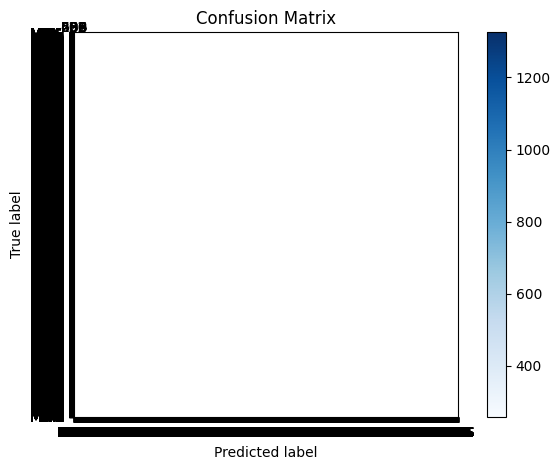

In [86]:
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix
import numpy as np

# Select only prediction and label columns
lr_prediction_label = preds.select(['prediction','label'])

# Build metrics for logistic regression
metrics = MulticlassMetrics(lr_prediction_label.rdd.map(tuple))

# Create confusion matrix
cnf_matrix = confusion_matrix(preds.select('label').toPandas(), preds.select('prediction').toPandas())

# Grab list of authors
authors = data.select('author').rdd.flatMap(lambda x: x).collect()

# Plot confusion matrix
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(authors))
plt.xticks(tick_marks, authors)
plt.yticks(tick_marks, authors)

# Label the matrix cells
thresh = cnf_matrix.max() / 2.
for i, j in np.ndindex(cnf_matrix.shape):
    plt.text(j, i, format(cnf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

# Add axis labels
# @todo fix matrix
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# Display accuracy
print(f'Logistic Regression had an accuracy of {metrics.accuracy}')